In [163]:
"""LiuKatrina_05.ipynb Harvard MCB 112 Problem Set 05: a mixure of five submitted by Xiao (Katrina) Liu"""
__author__      = "Katrina Liu"
__email__ = "xliu@hms.harvard.edu"
__date__ = "Oct 11, 2022"

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom

Before starting the exercise, we adopt the code from course write up to read data table and visualize the data and cluster assignment.

In [165]:
# Code adopted provided file from course website, original link: http://mcb112.org/w05/w05-visualize.py

def read_data(infile):
    '''
    read_data(infile)
    Read Lestrade's input file, w05-data.tbl, or a file in that format.
    Return:
       ctype[0..N-1] : cell types 0..Q-1 for each cell i
       data[i,g]     : array of count data; rows = cells i; cols = genes g
       N             : number of cells (rows of the data file)
       G             : number of genes (cols of the data file, after the first)
       Q             : number of cell types
    '''
    ctype = []
    data  = []
    with open(infile) as f:
        for line in f:
            if line[0] == '#': continue   # skip comment lines
            fields = line.split()
            ctype.append(int(fields[1]))
            data.append( [int(fields[2]), int(fields[3])])  # assumes exactly 2 genes!!
    ctype = np.array(ctype)
    data  = np.array(data)
    N, G  = np.shape(data)
    Q     = np.max(ctype) + 1
    return ctype, data, N, G, Q

def visualize_data(data, mu, C, outpng):
    '''
    visualize_data():

    This might give you a starting point that saves some matplotlib
    machinations; you can certainly spiff this up from here.

    Input:
       data[i,g] : count data for each cell i, for each gene g
       mu[q,g]   : array of mean counts for mixture q, gene g
       C[i]      : assignment of cell i to a cluster 0..Q-1
       outpng    : save figure to PNG file (must end in .png; example 'foo.png')

    '''
    N, G  = np.shape(data)
    Q, G2 = np.shape(mu)
    assert G == G2
    assert len(C) == N

    # We can assign colors to up to Q=10 components. If you want more, add more.
    colormap = ['xkcd:orange', 'xkcd:olive',     'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']

    fig, ax = plt.subplots()
    for i in range(N):
        edgecolor = colormap[ C[i]]
        fillcolor = 'w'
        shape     = 'o'
        ax.loglog( data[i,0], data[i,1], marker=shape, mec=edgecolor, mfc=fillcolor, mew=1.5)

    for q in range(Q):
        ax.loglog(mu[q,0], mu[q,1], '*k', ms=10)

    ax.set_xlabel('caraway (counts)')
    ax.set_ylabel('kiwi (counts)')

    fig.savefig(outpng)

# Exercise 1: reproduce Wiggins' K-means result
To implement our own kmeans algorithm, we first need measure to quantify the closeness between two samples. We will use the Euclidean distance of gene expressions as the distance between samples.
$$d_{\text{Euclidean}}(x_i,x_j) = \sqrt{(x_{i0}-x_{j0})^2+(x_{i1}-x_{j1})^2}$$

In [166]:
def euclid_dist(p1,p2):
    """
    Calculate the Euclidean distance between two data point
    :param p1: tuple/list-like 1-d array
    :param p2: tuple/list-like 1-d array
    :return: a scalar value representing the euclidean distances
    """
    return np.linalg.norm(p1-p2)

Then, we are able to perform the assignment step and update step of the kmeans algorithm.

- For the assignment step, we will need to assign each data point a cluster based on the input centroids, the assignment of data point $x_i$, $c_i$, is calculated as follows:
$$c_i = argmin_{j=0}^{k}d_{\text{Euclidean}}(\mu_{j},x_i)$$
- For the update step, we will need to update the centroids positions based on the new cluster assignment. The centroid of group i, $\mu_i$, can be calculated as follows:
$$\mu_i = \dfrac{\sum_{c_j = i} x_j}{|\{x_j|c_j = i\}|}$$
If no data point is assigned to group i, then we will use the previous centroid of group i.

In [167]:
def assignment(data, centroids):
    """
    Perform the assignment step of kmeans and identify the cluster where each data point belongs 
    to based on the current input centroids
    :param data: 2-d numpy array of shape (data_num, data_dim)
    :param centroids: 1-d array of length k/clust_num
    :return: 1-d integer array of clustering assignment
    """
    clusters = np.zeros(data.shape[0])
    for i in range(len(data)):
        p = data[i]
        dists = [euclid_dist(p,c) for c in centroids]
        clusters[i] = min(enumerate(dists), key=lambda x: x[1])[0]
    return clusters.astype(int)

def update(data, clusters, prev_centroids=None):
    """
    Calculate the new centroids based on the clustering assignment
    :param data: 2-d numpy array of shape (data_num, data_dim)
    :param clusters: 1-d integer array of clustering assignment
    :param prev_centroids: 1-d array of length k/clust_num containing previous centroids used when
                            no data point is assigned to the group.
    :return: 1-d array of length k/clust_num containing centroids
    """
    clust_num = max(clusters)+1
    data_dim = data.shape[1]
    centroids = np.zeros((clust_num,data_dim))
    for i in range(clust_num):
        clust_data = data[np.where(clusters == i)]
        if len(clust_data) == 0 and prev_centroids is not None:
            centroids[i] = prev_centroids[i]
        else:
            centroids[i] = np.mean(clust_data, axis=0)
    return centroids


After we finished implementing the substeps, we can put together the entire kmeans algorithm.
The algorithm will conduct the following steps:
- First, randomly generate k centroids position within the range of the data.
- Then, iteratively conduct the following two steps until convergence of clustering assignment or reached maximum number of iterations:
    - Assign each data point to the nearest centroid.
    - Update the centroid based on the assignment.
- Return the assignment and centroids

In [168]:
def kmeans(data, k, max_iter=50,init="random"):
    """
    Using the kmeans algorithm to cluster the input data into k groups
    :param data: 2-d numpy array of shape (data_num, data_dim)
    :param k: number of clusters
    :param max_iter: maximum number of iterations of assignments and upates
    :param init: initialization stategy
    :return: the cluster assignment, centroids caculated by kmeans algorithm.
    """
    data_dim = data.shape[1]
    init_centroids = data[:k,:]
    if init == "random":
        init_centroids = np.random.rand(k,data_dim)
        data_max = np.max(data, axis=0)
        data_min = np.min(data, axis=0)
        
        for i in range(data_dim):
            init_centroids[:,i] *= data_max[i]-data_min[i]
            init_centroids[:,i] += data_min[i]
    
    curr_centroids = init_centroids
    prev_assignment = assignment(data, curr_centroids)
    curr_assignment = prev_assignment

    for i in range(max_iter):
        curr_centroids = update(data, prev_assignment, curr_centroids)
        curr_assignment = assignment(data, curr_centroids)
        if np.array_equal(prev_assignment,curr_assignment):
            break
        prev_assignment = curr_assignment
    return curr_assignment, curr_centroids


We can use the total square distance of the data and the centroids obtained from the model to measure the accuracy of the model. We then use this metric to pick the best results obtained. The total square distance is calculated as follows: $$d_{\text{total square}}(X,\mu)=\sum_{i=0}^{N} d_{\text{Euclidean}}(X_i,\mu_{c_i})^2$$

In [169]:
def total_sqdist(data,centroids, clusters):
    """
    Calculate the total square distance based on the data, centroids obtained from model, 
    and cluster assignments
    :param data: 2-d numpy array of shape (data_num, data_dim)
    :param centroids: 1-d array of length k/clust_num
    :param clusters: 1-d integer array of clustering assignment
    :return: the total squared distance
    """
    total_dist = 0
    cluster_num = len(centroids)
    for i in range(data.shape[0]):
        p = data[i]
        c = centroids[clusters[i]]
        diff = c-p
        total_dist += np.inner(diff,diff)
    return total_dist

In [170]:
def find_min_tsqd(data,k, iter = 5):
    """
    Use total square distance as a metric to find the paramters of the best model
    :param data: 2-d numpy array of shape (data_num, data_dim)
    :param k: number of clusters
    :param iter: number of times model run with different initialized centroids 
    :return: lowest squared distance, 1-d integer array of best clustering assignment, 
            1-d array of length k/clust_num of best centroids
    """
    min_dist = np.Inf
    min_assignment = []
    min_centroids = []
    for _ in range(iter):
        asgn, cent = kmeans(data,k)
        sqd = total_sqdist(data, cent, asgn)
        if sqd < min_dist:
            min_dist = sqd
            min_assignment = asgn
            min_centroids = cent
    return min_dist, min_assignment, min_centroids

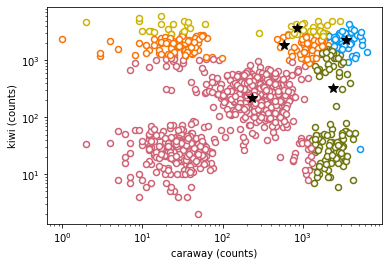

In [171]:
# Read Wiggins' data and perform kmeans algorithm, visualiza the best clustering results
true_label, wiggins_data,_,_,ctype_num = read_data("w05-data.tbl")
min_wiggins_d, min_wiggins_asgn, min_wiggins_cent = find_min_tsqd(wiggins_data,ctype_num)
visualize_data(wiggins_data,min_wiggins_cent,min_wiggins_asgn,"wiggins_reproduced.png")

## Analysis
The kmeans algorithm is producing this result because we are using euclidean distances directly on the raw gene expression data. As we can see, the five distinct clusters are plotted on the scale of exponential values on the axis. However, they are actually on the scale of exponents as $10^0, 10^1, 10^2,...$. Therefore, this cannot be reflected directly through Euclidean distances, which our kmeans algorithm is based on, resulting in poorly clustered data.

# Exercise 2: mixture negative binomial fitting
Before the actual implementation of the model, we will need to store the constant dispersion level $\phi=0.3$ and know how to convert the parameters for the two interpretation of negative binomial distribution. The parameters conversion is conducted as follows: $$n = \dfrac{1}{\phi}$$$$p=\dfrac{1}{1+\mu\phi}$$

In [172]:
# Store the dispersion value
DISPERSION = 0.3

In [173]:
def convert_nbinom(mu,dispersion):
    """
    Convert the mean and variance of negative binomial parameters to regular n and p
    :param mu: mean
    :param dispersion: variance
    :return: n, p
    """
    return 1/dispersion, 1/(1+mu*dispersion)

Now, we are able to implement the expectation step and maximization step of the mixture negative binomial model. 
- For the expectation step: we will use the data $X$, centroids $\mu$, dispersion level $\phi$, and mixture coefficients $\pi$ to calculate the posterior probabilities $P(q|X_i, \mu, \phi, \pi)$.
$$P(q|X_i, \mu_q, \phi, \pi) = \dfrac{\pi_{q}P(X_{i0}|\mu_{q0},\phi)P(X_{i1}|\mu_{q1},\phi)}{\sum_q \pi_{q}P(X_{i0}|\mu_{q0},\phi)P(X_{i1}|\mu_{q1},\phi)}$$
- For the maximization step: we will use the data $X$ and posterior probabilities to calculate the new centroids and mixture coefficients.
$$\hat{\mu_q} = \dfrac{X_{i}P(q|X_i,\mu_q,\phi,\pi)}{\sum_i P(q|X_i,\mu_q,\phi,\pi)}$$
$$\hat{\pi_q} = \dfrac{\sum_i P(q|X_i,\mu_q,\phi,\pi)}{Q}$$

In [174]:
def expectation(data, mus,dispersion, mix_coeffients):
    """
    Calculate posterior probabilities
    :param data: 2-d numpy array of shape (data_num, data_dim)
    :param mus: a 1-d array of length Q centroids
    :param dispersion: a scalar of variance
    :param mix_coefficients: a 1d-array of length Q mixture component coefficients
    :return: a 2d-numpy array of shape [N, Q] of posterior probabilities, total log likelihood
    """
    mix_comp_num = len(mix_coeffients)
    data_len, data_dim = data.shape
    posterior_probs = np.ones((data_len, mix_comp_num))/mix_comp_num
    total_log_likelihood = 0
    for i in range(mix_comp_num):
        comp_n, comp_p = convert_nbinom(mus[i], dispersion)
        for d_i in range(data_len):
            d = data[d_i]
            prob = mix_coeffients[i]
            for j in range(data_dim):
                prob *= nbinom.pmf(d[j], comp_n, comp_p[j])
                total_log_likelihood += nbinom.logpmf(d[j], comp_n, comp_p[j])
            posterior_probs[d_i, i] = prob
    return posterior_probs/posterior_probs.sum(axis=1, keepdims=1), total_log_likelihood

def maximization(data, posterior_prob):
    """
    Calculate new centroids and mixture coefficients
    :param data: 2-d numpy array of shape (data_num, data_dim)
    :param posterior_prob: a 2d-numpy array of shape [N, Q] of posterior probabilities
    :return: a 1d-array of length Q of new centroids, a 1d-array of length Q of new mixture 
            coefficients
    """
    comp_num = posterior_prob.shape[1]
    data_len, data_dim = data.shape
    new_mix_coefficients = posterior_prob.sum(axis=0)/data_len
    new_mus = np.zeros((comp_num, data_dim))
    for i in range(comp_num):
        comp_mu = new_mus[i]
        for j in range(data_len):
            comp_mu += data[j]*posterior_prob[j,i]
        new_mus[i] = comp_mu/sum(posterior_prob[:,i])       
    return new_mus, new_mix_coefficients


After we have completed the substeps, we can put together the complete EM algorithm for the mixture negative binomial model. We will use the total log likelihood as a metric to measure the accuracy of the model.

In [175]:
def EM_nbinom(data, k, dispersion, init = "random", max_iter = 50):
    """
    Cluster the data into k groups with estimation maximization algorithm based on a mixture of 
    negative binomial models
    :param data: 2-d numpy array of shape (data_num, data_dim)
    :param k: Q
    :param dispersion: variance
    :param init: initialization strategy
    :param max_iter: maximum number of iterations
    :return: best posterior probabilities, best centroids, best mixture coefficients, 
            best total log likelihood
    """
    data_dim = data.shape[1]
    init_mix_coefficient = np.ones(k)/k
    init_mus = data[:k,:]
    if init == "random":
        init_mus = np.random.rand(k,data_dim)
        data_max = np.max(data, axis=0)
        data_min = np.min(data, axis=0)
        
        for i in range(data_dim):
            init_mus[:,i] *= data_max[i]-data_min[i]
            init_mus[:,i] += data_min[i]
    curr_mus = init_mus
    curr_mix_coefficient = init_mix_coefficient
    prev_prob, prev_total_log_llh = expectation(data,init_mus,dispersion, init_mix_coefficient)
    for _ in range(max_iter):
        curr_mus, curr_mix_coefficient = maximization(data, prev_prob)
        curr_prob, curr_total_log_llh = expectation(data, curr_mus,dispersion, curr_mix_coefficient)
        if np.isclose(curr_total_log_llh, prev_total_log_llh) and np.allclose(prev_prob,curr_prob):
            break
        prev_prob = curr_prob
        prev_total_log_llh = curr_total_log_llh
    return curr_prob, curr_mus, curr_mix_coefficient, curr_total_log_llh



To get the clustering assignment from the model, we use the posterior probability to identify the cluster assignment by the finding the model with highest posterior probability of the sample. We also run the model multiple times with random starting centroids and pick the best model with the highest total log likelihood.

In [176]:
def get_cluster_from_probs(probs):
    """
    Assign clusters to each data based on the posterior probability
    :param probs: a 2d-numpy array of shape [N, Q] of posterior probabilities
    :return: 1d array of cluster assignment
    """
    return np.array([max(enumerate(d), key=lambda x:x[1])[0] for d in probs])


def get_best_total_log_llh(data, k, dispersion, iters = 5):
    """
    Run the mixture model multiple times and return paramters with the best model 
    with highest total log likelihood
    :param data: 2-d numpy array of shape (data_num, data_dim)
    :param k: Q
    :param dispersion: variance
    :param iters: number of times model run with different initial centroids.
    :return: parameters of the best model
    """
    max_total_log_llh = np.NINF
    max_params = []
    for _ in range(iters):
        res = EM_nbinom(data,k,dispersion)
        if res[-1] > max_total_log_llh:
            max_total_log_llh = res[-1]
            max_params = res
    return max_params


Then, we will be able to find the best parameters for the mixture model useing EM algorithm. 

Best centroids found:  [[2084.05287386 2017.1301688 ]
 [  29.63649846 2061.73446362]
 [ 301.18795547  294.91251152]
 [2066.54636749   30.45661902]
 [  31.27056055   29.17828139]]
The relative proportion of five cell types:  [0.19106411 0.11824216 0.37818557 0.10152667 0.2109815 ]


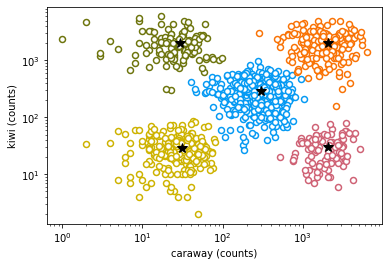

In [177]:
# Obtain the clusters with the best total log llh, takes about 5 minutes to run
best_fit = get_best_total_log_llh(wiggins_data,ctype_num,DISPERSION)
best_clust = get_cluster_from_probs(best_fit[0])
print("Best centroids found: ", best_fit[1])
print("The relative proportion of five cell types: ", best_fit[2])
visualize_data(wiggins_data,best_fit[1], best_clust, "wiggins_em.png")

# Exercise 3: find a simple fix for K-means
The simple fix would just be taking the log of the data based on the analysis in exercise 1 and rerun it with kmeans model to get the clustering information.

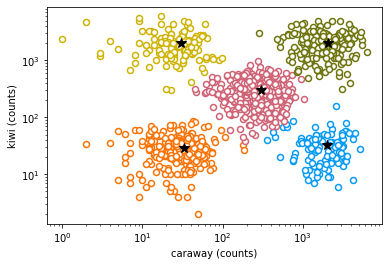

In [178]:
# Take the log of base 10 of the gene expression data
log10_data = np.log10(wiggins_data)

# Find the cluster assignment
min_log_d, min_log_asgn, min_log_cent = find_min_tsqd(log10_data,ctype_num)
min_reg_cent = update(wiggins_data,min_log_asgn)
print("Best centroids of clusters: ", min_reg_cent)
visualize_data(wiggins_data,min_reg_cent,min_log_asgn,"wiggins_fixed.png")